# 3. K2 instrumental signals  
## I. Getting the PSD of the instrumental artifacts I: empty pixels

M. Gully-Santiago  
July 2019
Kepler/K2 GO Office


In [1]:
import numpy as np
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.timeseries import LombScargle

In [2]:
import scope
import lightkurve as lk
import everest

Let's turn off `DEBUG` logging messages.

In [4]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 
bok_log = logging.getLogger('bokeh') 
bok_log.setLevel(logging.WARNING) 
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

# What does the background look like in a PSD?

First let's get nearby star background pixels.

In [5]:
search_result = lk.search_targetpixelfile('EPIC 220182448', mission='K2', cadence='long', campaign=8, radius=21*u.arcminute)

In [6]:
search_result

SearchResult containing 81 data products.

 target_name           productFilename                        description                   distance     
------------- ---------------------------------- ------------------------------------- ------------------
ktwo220182448 ktwo220182448-c08_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C08                0.0
ktwo220183149 ktwo220183149-c08_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C08 102.76518279244229
ktwo220181541 ktwo220181541-c08_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C08 159.43296415355397
ktwo220180981 ktwo220180981-c08_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C08 203.04723702308613
ktwo220181478 ktwo220181478-c08_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C08   203.785305101939
ktwo220182716 ktwo220182716-c08_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C08 206.20350080747977
ktwo220183084 ktwo220183084-c08_lpd-targ.fits.gz Target Pixel Long Cadence (KTL) - C08 254.34604187445106
ktw

In [11]:
tpfs = search_result.download_all()

For each tpf let's examine and assign source-free background pixels.

In [12]:
lc = tpfs[0].to_lightcurve()

## Data pre-processing

#### What do do about non-uniform time sampling?

In [13]:
t_gaps = ((lc.time[1:] - lc.time[0:-1])*u.day).to(u.hour)

In [14]:
np.max(t_gaps)

<Quantity 1.9614773 h>

The largest gap is four consecutive 30-minute cadences.

In [15]:
t = (lc.time*u.day).to(u.second).value
NN = len(lc.time)

## Compute the normalized power spectra with two methods

In [16]:
fake_omega = np.logspace(-6, -4, base=10)
fake_pow = fake_omega**(-2) *1e5

In [17]:
f = np.fft.rfftfreq(len(t), t[1] - t[0])

In [28]:
# Compute the LS based power spectrum estimates
power_ls = []
power_white_noise = []
power_bkg = []
for tpf in tpfs:
    background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
    ncad, nx, ny = tpf.flux.shape
    y_vector = tpf.flux.reshape(ncad, nx*ny)[:, background_mask.reshape(nx*ny)]
    noise_vector = tpf.flux_err.reshape(ncad, nx*ny)[:, background_mask.reshape(nx*ny)]
    bkg_vector = tpf.flux_bkg.reshape(ncad, nx*ny)[:, background_mask.reshape(nx*ny)]
    i=0
    for pixel_lc in y_vector.T:
        model = LombScargle(t, pixel_lc)
        power_ls.append(model.power(f[1:-1], method="fast", normalization="psd"))
    for noise_amp in noise_vector.T:
        y0 = np.random.normal(loc=np.zeros(len(noise_amp)), scale=noise_amp)
        model = LombScargle(t, y0)
        power_white_noise.append(model.power(f[1:-1], method="fast", normalization="psd"))
    for pixel_bkg in bkg_vector.T:
        model = LombScargle(t, pixel_bkg)
        power_bkg.append(model.power(f[1:-1], method="fast", normalization="psd"))
power_ls = np.array(power_ls)
power_white_noise = np.array(power_white_noise)
power_bkg = np.array(power_bkg)

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= NN
power_white_noise /= NN
power_bkg /= NN

The AGN target

In [61]:
tpf = tpfs[0]

In [62]:
lc = tpf.to_lightcurve(aperture_mask=tpf.create_threshold_mask())

In [63]:
n_pix = tpf.create_threshold_mask().sum()

In [64]:
n_pix

20

In [75]:
model = LombScargle(t, lc.flux/np.sqrt(n_pix)**2)
power_AGN = model.power(f[1:-1], method="fast", normalization="psd") / NN

In [76]:
t_motion = (6.0*u.hour).to(u.second)

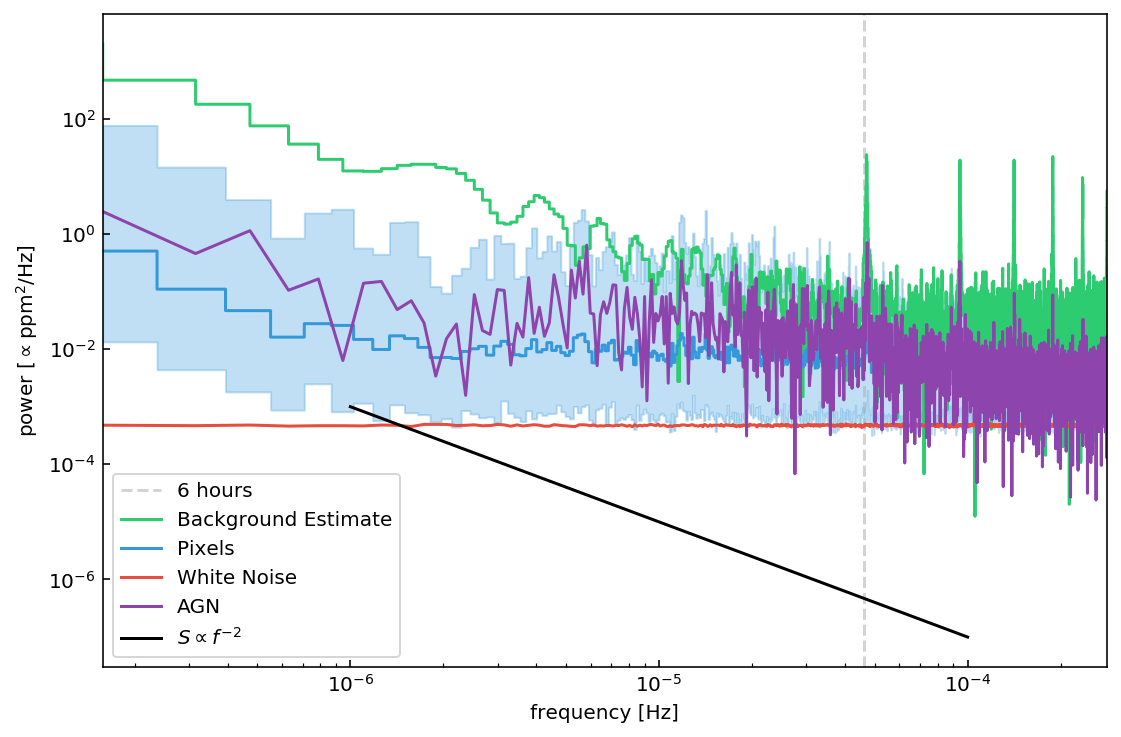

In [77]:
plt.figure(figsize=(9,6))
plt.axvline(1.0/t_motion.value, color='#aaaaaa', linestyle='dashed', label='6 hours', alpha=0.5)
percentile = 50
plt.step(f[1:-1], np.nanpercentile(power_bkg,percentile, axis=0), "-", label="Background Estimate", color='#2ecc71')

plt.step(f[1:-1], np.nanpercentile(power_ls,percentile, axis=0), label="Pixels", color='#3498db', where='mid')
plt.fill_between(f[1:-1], 
                 np.nanpercentile(power_ls,5, axis=0),
                 np.nanpercentile(power_ls,95, axis=0),
                 label=None, color='#3498db', alpha=0.3, step='mid')

plt.plot(f[1:-1], np.nanpercentile(power_white_noise,percentile, axis=0), "-", label="White Noise", color='#e74c3c')

plt.plot(f[1:-1], power_AGN, "-", label="AGN", color='#8e44ad')

plt.yscale("log")
plt.xscale("log")
plt.xlim(f[1:].min(), f.max())
plt.ylabel("power [$\propto \mathrm{ppm}^2/\mathrm{Hz}$]")
plt.xlabel("frequency [Hz]")

plt.plot(fake_omega, fake_pow/np.max(fake_pow)/1000, 'k-', label='$S \propto f^{-2}$')

plt.legend(loc='best');

Wide range of empty pixel signals.